In [99]:
%matplotlib inline
import os
import math
import shutil
import pickle
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

import IPython.display as ipd

import librosa
from librosa.display import specshow

from IPython.display import Audio

In [2]:
# check permissions
# read
DATA_FOLDER = '/projects/data/data_v_7_stc'
METAFOLDER = os.path.join(DATA_FOLDER, 'meta')
METAFILE = os.path.join(METAFOLDER, 'meta.txt')
AUDIO_FOLDER = os.path.join(DATA_FOLDER, 'audio')

# write
REFINED_FOLDER = os.path.join(DATA_FOLDER, 'refined', '')
REFINED_META = os.path.join(METAFOLDER, 'refined_meta.txt')

In [3]:
df = pd.read_csv(METAFILE, sep='\t', header=None)
df.columns = ['file', 'unk1', 'unk2', 'duration', 'type']

In [24]:
df.sample(5)

file    unk1  unk2  duration        type
489    background_0033_time_stretch_4.wav  office     0  5.130068  background
3733            d_0025_time_stretch_9.wav  office     0  1.315828        door
2265       t_bags_0052_time_stretch_3.wav  office     0  3.144399        bags
11100                       tool_1453.wav  office     0  4.000000        tool
3238         door_0063_time_stretch_4.wav  office     0  1.520907        door

In [31]:
uniqs = df['type'].unique()

# Find file count of each type

In [32]:
rows_count = lambda df, t: len(df.loc[df['type'] == t].index)
type_freqs = {name: rows_count(df, name) for name in uniqs}

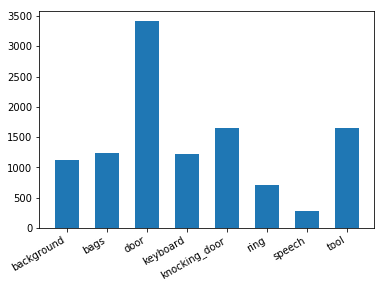

In [33]:
plt.bar(range(len(type_freqs)), list(type_freqs.values()), align='center', width=0.6)
plt.xticks(range(len(type_freqs)), list(type_freqs.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right') 
 
plt.show()

# Find average durations

In [34]:
avg_duration = lambda df, t: df.loc[df['type'] == t]['duration'].mean()
type_avg_durations = {name: avg_duration(df, name) for name in uniqs}

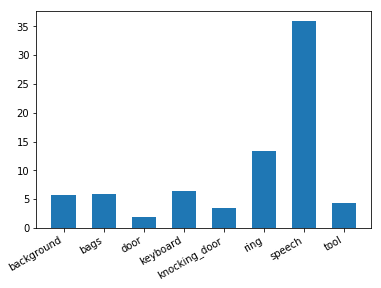

In [35]:
plt.bar(range(len(type_avg_durations)), list(type_avg_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_avg_durations)), list(type_avg_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Find total durations

In [36]:
total_duration = lambda df, t: df.loc[df['type'] == t]['duration'].sum()
type_durations = {name: total_duration(df, name) for name in uniqs}

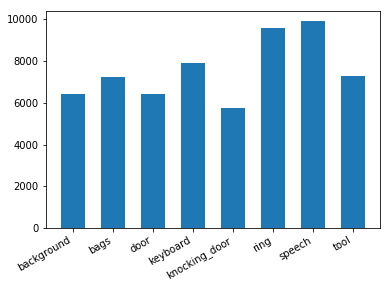

In [37]:
plt.bar(range(len(type_durations)), list(type_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_durations)), list(type_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Analyze sounds

### Histogram of file durations

Text(0.05, 0.5, 'file count')

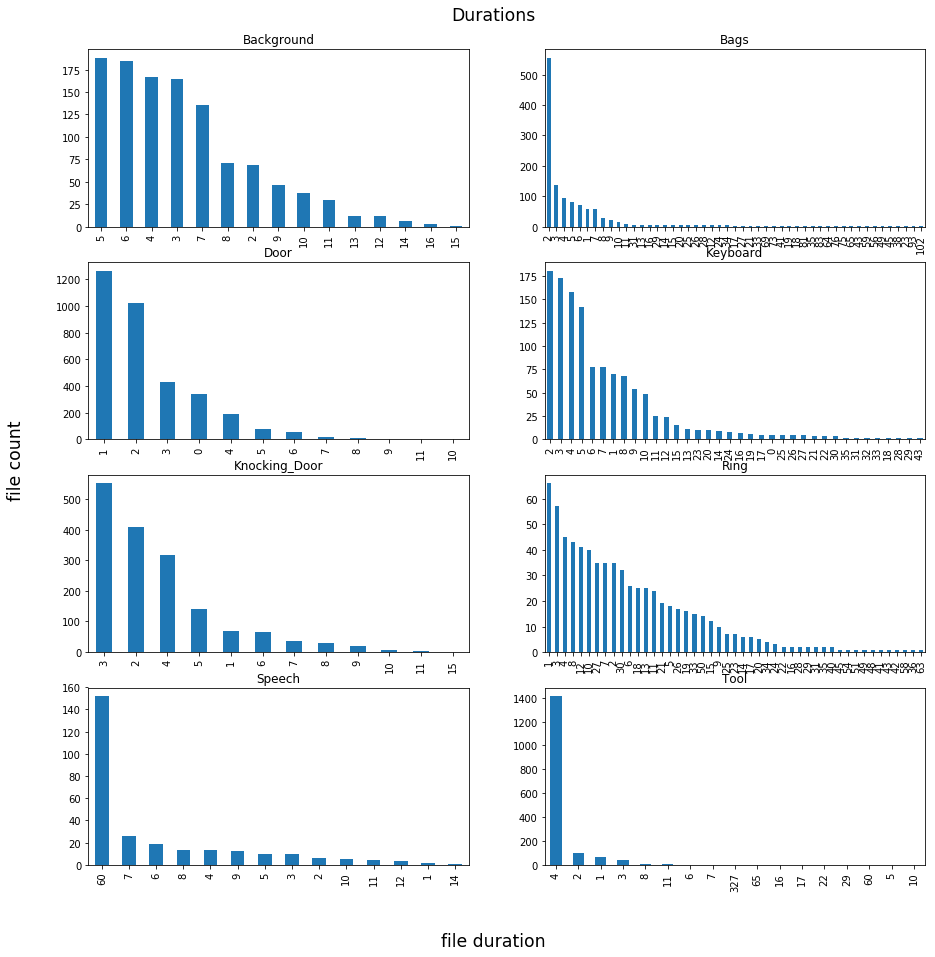

In [38]:
temp_df = pd.DataFrame()
temp_df['duration'] = df['duration'].map(lambda x: round(x))
temp_df['type'] = df['type']

fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = temp_df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    temp_df.loc[temp_df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

# Process data

## Pickle features

In [9]:
FRAME_SIZE = 1024
OVERLAP = 4
HOP = FRAME_SIZE // OVERLAP
MELS = 30

In [77]:
feats = []
out_path = os.path.join(DATA_FOLDER, 'mels.pickle')

In [ ]:
feats = []
refined_df = df.sample(frac=1)
refined_df = pd.get_dummies(refined_df, columns=['type'])

for _, row in tqdm(refined_df.iterrows()):
    file = row['file']
    typ = row.values[4:].astype(int)
    filepath = os.path.join(AUDIO_FOLDER, file)
    y, sr = librosa.load(filepath)
    mels = librosa.feature.melspectrogram(y, n_fft=FRAME_SIZE, hop_length=HOP, n_mels=MELS, fmax=sr // 2)
    log_mels = librosa.core.power_to_db(mels, ref=np.max)
    feats.append({
        'file': file,
        'type': typ,
        'log_mel': log_mels,
    })
    
with open(out_path, 'wb') as f:
    pickle.dump(feats, f)    

In [80]:
with open(out_path, 'rb') as f:
    feats = pickle.load(f)

In [ ]:
# [ x ] перемешать
# [  ] поделить на тестовую и тренировочную
# [  ] привести к форме
# [ x ] признак в вектор

In [81]:
feats[0]

{'file': 't_door_0080_time_stretch_4.wav',
 'type': array([0, 0, 1, 0, 0, 0, 0, 0]),
 'log_mel': array([[-78.57396643, -77.67809296, -77.36153843, ..., -45.3343083 ,
         -49.54960957, -49.67084521],
        [-80.        , -80.        , -80.        , ..., -38.90496948,
         -42.16092651, -43.0883342 ],
        [-80.        , -80.        , -80.        , ..., -38.38805964,
         -37.83294174, -37.60096994],
        ...,
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -72.39792041],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -72.32409047],
        [-80.        , -80.        , -80.        , ..., -80.        ,
         -80.        , -68.73303318]])}

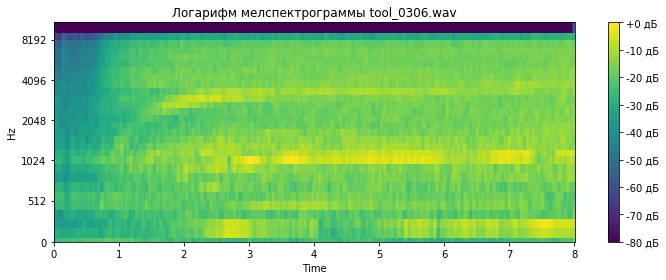

In [103]:
n = random.randint(0, len(feats))
plt.figure(figsize=(10, 4))
specshow(feats[n]['log_mel'], y_axis='mel',
         fmax=sr//2, x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы {}'.format(feats[n]['file']))
plt.tight_layout()
plt.show()

Audio(filename=os.path.join(AUDIO_FOLDER, feats[n]['file']))

In [109]:
class Config:
    def __init__(self, shape):
        self.shape = shape
        
config = Config((MELS, 64, 1))

def prepare_shape(feature, config):
    tmp = feature
    N = config.shape[1]
    while tmp.shape[1] < N:
        tmp = np.hstack((tmp, tmp))
    r_offset = np.random.randint(tmp.shape[1] - N + 1)
    tmp = tmp[:, r_offset: r_offset + N, np.newaxis]
    return tmp

In [110]:
prepare_shape(feats[0]['log_mel'], config).shape

(30, 64, 1)

# Create smth for ml

### -1) additional imports

### 0) load dataframe

In [3]:
refined_df = pd.read_csv(REFINED_META, sep='\t')

### 1) shuffle dataframe and create categorical column for type

In [4]:
refined_df = refined_df.sample(frac=1).reset_index(drop=True)

In [5]:
refined_df.type = pd.Categorical(refined_df.type)
refined_df['code'] = refined_df.type.cat.codes

### 2) create train data generator

In [ ]:
class Trainer(keras.utils.Sequence):
    pass

### 3) Create, compile, train model (не работает)

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D

# конфиг:
# - 2 слоя Conv2D
# - слой Flatten
# - 2 слоя Dense
# - активационная функция softmax

input_shape = (16, 10, 1)

model = Sequential([
    Conv2D(16, kernel_size=(2, 2), input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3)),
    Flatten(),
    Dense(16),
    Dense(16),
    Activation('softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit_generator(train_generator(), steps_per_epoch=10, epochs=10, verbose=1)

Epoch 1/10
/projects/data/data_v_7_stc/refined/ring_0539__3.wav
/projects/data/data_v_7_stc/refined/d_0082_time_stretch_13__0.wav


TypeError: object of type 'Tensor' has no len()

In [66]:
tg = train_generator()

In [67]:
item = next(tg)
item[0]

/projects/data/data_v_7_stc/refined/ring_0539__3.wav


<tf.Tensor 'Reshape_3:0' shape=(171, 16, 1) dtype=float32>

In [40]:
(*(item[0].shape), 1)

(Dimension(171), Dimension(16), 1)